# Load Libraries

In [2]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [3]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [4]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
            #  legend.title = element_blank(),
            #  legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=6, height=4.5, units=c("in"))
  # embed_font(path)
}

# Connect to DB, load data, clean data

In [5]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [6]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT *
    FROM tarball_analysis.what_did_updates_change
")

In [7]:
all_updates_sub <- all_updates[sample(nrow(all_updates), 100000),] 

In [8]:
all_updates <- all_updates %>% filter(ty != "zero_to_something")

In [9]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- factor(all_updates$ty, levels=c("bug", "minor", "major"))

In [10]:
head(all_updates)

,from_id,to_id,package_id,ty,from_created,to_created,did_intro_vuln,did_patch_vuln,did_change_types,did_change_code,did_add_dep,did_remove_dep,did_modify_dep_constraint,did_change_json_scripts,tyFact
,<int64>,<int64>,<int64>,<chr>,<dttm>,<dttm>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>
1,45406,45407,44333,bug,2017-05-18 06:18:45,2017-05-18 06:27:38,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
2,62778,62779,62967,bug,2017-07-26 00:40:30,2017-07-26 21:40:16,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
3,62779,62780,62967,bug,2017-07-26 21:40:16,2017-07-26 21:52:26,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,bug
4,62781,62782,62968,minor,2017-07-24 11:54:37,2017-07-28 12:12:29,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,minor
5,62783,62784,62969,bug,2017-07-28 11:52:04,2017-07-28 12:01:41,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug
6,62785,62786,62972,bug,2017-07-26 22:16:20,2017-07-26 22:47:30,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,bug


In [11]:
all_updates <- all_updates %>% mutate(
    did_change_deps = did_add_dep | did_remove_dep | did_modify_dep_constraint,
    only_change_deps = (did_add_dep | did_remove_dep | did_modify_dep_constraint) & !(did_change_types | did_change_code | did_change_json_scripts),
    only_change_types = (did_add_dep | did_remove_dep | did_modify_dep_constraint) & !(did_change_types | did_change_code | did_change_json_scripts)
)

In [12]:
all_updates %>% summarize(total_did_change_deps=sum(did_change_deps))

total_did_change_deps
<int>
5479605


In [13]:
as.data.frame(confusionMatrix(factor(all_updates$did_change_deps), factor(all_updates$did_change_code))$table)

Prediction,Reference,Freq
<fct>,<fct>,<int>
FALSE,FALSE,3680405
TRUE,FALSE,2985068
FALSE,TRUE,5743011
TRUE,TRUE,2494537


In [14]:
plot_change_deps_vs_code <- function(df, update_type) {
        cm <- confusionMatrix(factor(df$did_change_deps), factor(df$did_change_code)) # preds, refs
        cm <- as.data.frame(cm$table)
        # cm$Prediction <- factor(cm$Prediction, levels=rev(levels(cm$Prediction)))
        # cm <- cm %>% mutate(Freq = Freq / sum(Freq))

        ggplot(cm, aes(Prediction,Reference, fill=Freq / sum(Freq))) +
                geom_tile() + geom_text(aes(label=scales::percent(Freq / sum(Freq)))) +
                scale_fill_gradient(low="white", high="#009194") +
                labs(x = "Changed Dependencies", y = "Changed .js / .jsx / .ts / .tsx code") +
                ggtitle(paste("Contents of updates among", update_type, "updates"))
                # scale_x_discrete(labels=c("Class_1","Class_2")) +
                # scale_y_discrete(labels=c("Class_4","Class_3"))

        ggsave(paste("plots/rq4/contents_heat_", update_type, ".pdf", sep=""))
}

# plot_change_deps_vs_code(all_updates, "all")
# plot_change_deps_vs_code(all_updates %>% filter(ty == "bug"), "bug")
# plot_change_deps_vs_code(all_updates %>% filter(ty == "minor"), "minor")
# plot_change_deps_vs_code(all_updates %>% filter(ty == "major"), "major")

# Make plots!

### What proportion of each package's update are each type?

In [15]:
# creates a data frame with one row per package, and columns for count of each update type
update_changes_by_pkg <- all_updates %>%
    group_by(package_id,tyFact,did_change_deps,did_change_code) %>%
    summarise(
        count = n()
    ) %>% mutate(
        change=ifelse(did_change_deps & did_change_code, "both", ifelse(did_change_deps, "deps", ifelse(did_change_code, "code", "none"))),
    ) %>% pivot_wider(names_from = change, values_from = count, values_fill=0) %>%
    group_by(package_id,tyFact) %>% summarise(
        # total = sum(both, deps, code, none),
        # bothPct = both / total,
        # depsPct = deps / total,
        # codePct = code / total,
        # nonePct = none / total
        total_deps = sum(deps),
        total_code = sum(code),
        total_both = sum(both),
        total_none = sum(none),
    ) %>% mutate(
        total = total_deps + total_code + total_both + total_none,
        bothPct = total_both / total,
        depsPct = total_deps / total,
        codePct = total_code / total,
        nonePct = total_none / total
    ) %>% pivot_longer(
        cols = ends_with("Pct"),
        names_to = "change",
        values_to = "pct"
    ) 
    
    # %>% ggplot(aes(x = tyFact, y = pct, fill = change)) +
    
    # %>% pivot_longer(
    #     cols = starts_with("none"),
    #     names_to = "change",
    #     values_to = "pct"
    # ) %>% ggplot(aes(x = tyFact, y = pct, fill = change)) +
    # mutate(total = bug + minor + major,
    #        bugPct = bug / total,
    #        majorPct = major / total,
    #        minorPct = minor / total,
    # ) %>%
    # mutate(update_action = ifelse(did_intro_vuln, 'Intro vuln', ifelse(did_patch_vuln, 'Patch vuln', 'No security effect')))

`summarise()` has grouped output by 'package_id', 'tyFact', 'did_change_deps'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'package_id'. You can override using the
`.groups` argument.


In [16]:
update_changes_by_pkg

package_id,tyFact,total_deps,total_code,total_both,total_none,total,change,pct
<int64>,<fct>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>
335,bug,2,73,1,74,150,bothPct,0.006666667
335,bug,2,73,1,74,150,depsPct,0.013333333
335,bug,2,73,1,74,150,codePct,0.486666667
335,bug,2,73,1,74,150,nonePct,0.493333333
335,minor,2,139,22,19,182,bothPct,0.120879121
335,minor,2,139,22,19,182,depsPct,0.010989011
335,minor,2,139,22,19,182,codePct,0.763736264
335,minor,2,139,22,19,182,nonePct,0.104395604
335,major,1,6,4,1,12,bothPct,0.333333333


In [17]:
update_changes_by_pkg$tyFact <- recode(update_changes_by_pkg$tyFact, bug='Bug', minor='Minor', major='Major')


In [18]:
update_changes_by_pkg$change <- recode(update_changes_by_pkg$change, nonePct='Neither', bothPct='Both', depsPct='Dependencies', codePct='.js / .jsx / .ts / .tsx')
update_changes_by_pkg$change <- factor(update_changes_by_pkg$change, levels=c('Neither', 'Dependencies', '.js / .jsx / .ts / .tsx', 'Both'))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


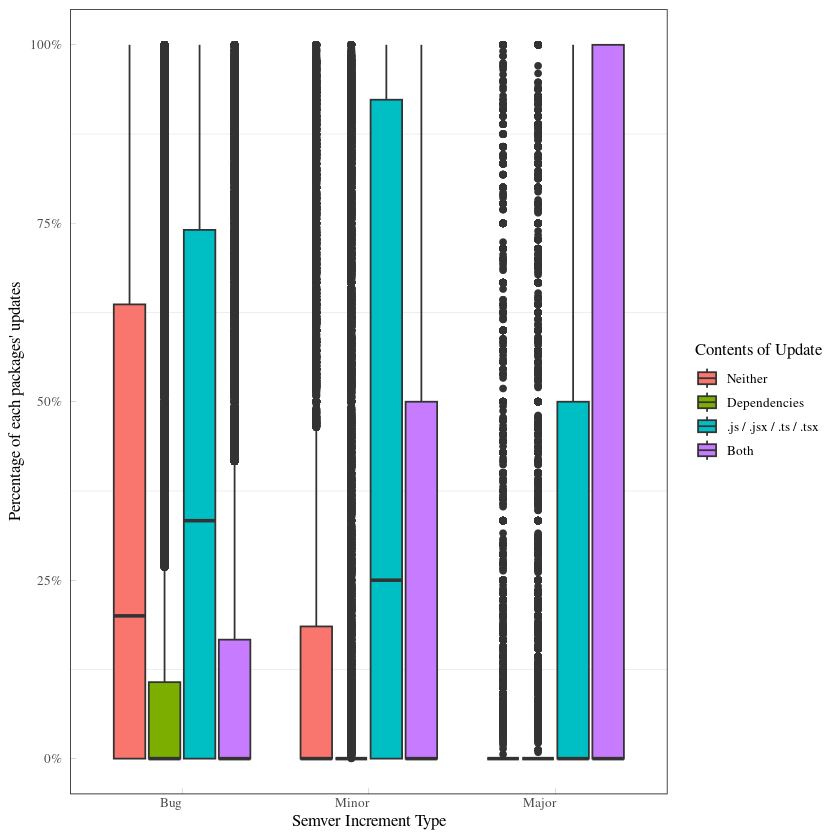

In [19]:
# box plots of the percentage of updates that are each type
ggplot(data = update_changes_by_pkg, aes(x = tyFact, y = pct, fill=change)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(
        # title = "Percentage of each category of update contents across semver increment types", 
        fill='Contents of Update', x='Semver Increment Type', y = 'Percentage of each packages\' updates') +
    mytheme()

mysave("plots/rq4/contents_box_plot.png")

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead.”


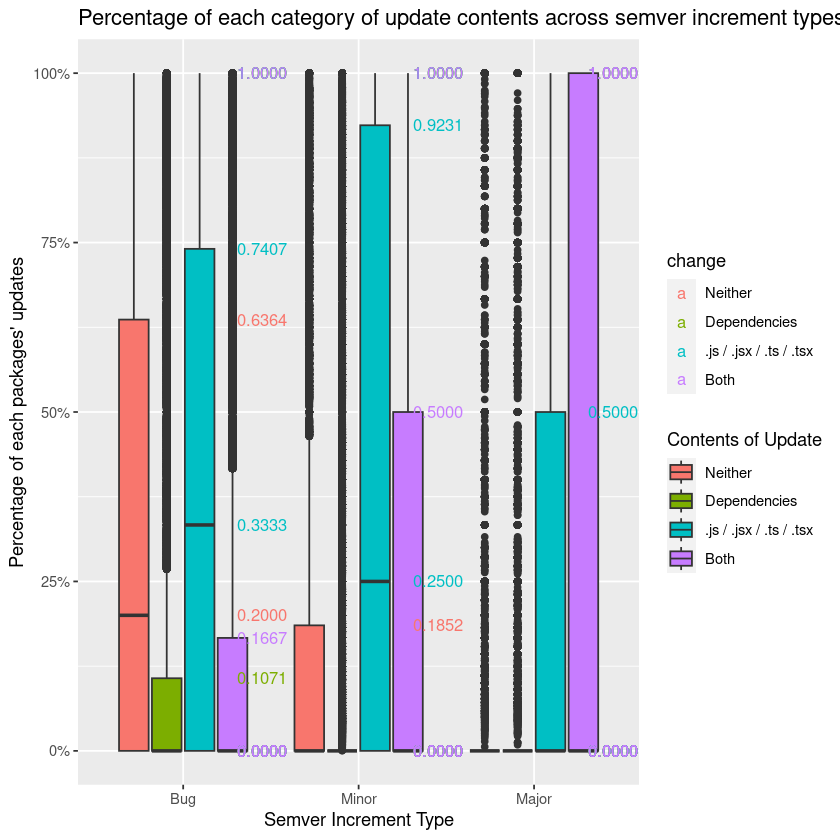

In [20]:
ggplot(data = update_changes_by_pkg, aes(x = tyFact, y = pct, fill=change)) +
    geom_boxplot() +

    stat_summary(geom="text", fun.y=quantile,
               aes(label=sprintf("%1.4f", ..y..), x=tyFact, color=change),
               position=position_nudge(x=0.45), 
               size=3.5) +

    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(
        title = "Percentage of each category of update contents across semver increment types", 
        fill='Contents of Update', x='Semver Increment Type', 
        y = 'Percentage of each packages\' updates')


In [24]:
update_changes_by_pkg %>% pivot_wider(names_from = change, values_from = pct, values_fill=0) %>% ungroup() %>% summarize(num_updates = sum(total))

num_updates
<int>
14903021


In [25]:
n_distinct(update_changes_by_pkg$package_id)

[1] 1339684

In [21]:
update_changes_by_pkg

# %>% pivot_longer(
#         cols = ends_with("Pct"),
#         names_to = "change",
#         values_to = "pct"
#     ) 

package_id,tyFact,total_deps,total_code,total_both,total_none,total,change,pct
<int64>,<fct>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>
335,Bug,2,73,1,74,150,Both,0.006666667
335,Bug,2,73,1,74,150,Dependencies,0.013333333
335,Bug,2,73,1,74,150,.js / .jsx / .ts / .tsx,0.486666667
335,Bug,2,73,1,74,150,Neither,0.493333333
335,Minor,2,139,22,19,182,Both,0.120879121
335,Minor,2,139,22,19,182,Dependencies,0.010989011
335,Minor,2,139,22,19,182,.js / .jsx / .ts / .tsx,0.763736264
335,Minor,2,139,22,19,182,Neither,0.104395604
335,Major,1,6,4,1,12,Both,0.333333333
